In [2]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

from graphviz import Source
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dowhy.__version__

'0.7.1'

In [4]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## 1. Matching with a confounder

### Read the data

In [5]:
dex_sample_data = pd.read_csv('dex-sample.csv')

In [6]:
dex_sample_data = pd.read_csv('dex-sample.csv')

In [10]:
dex_sample_data

,RT,GameAssignmentSuccess,Score
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0
...,...,...,...
195,35,True,180059.0
196,19,False,113031.0
197,38,False,184837.0
198,19,False,111382.0


In [7]:
dex_sample_data.shape

In [8]:
dex_sample_data.head()

,RT,GameAssignmentSuccess,Score
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [9]:
dex_sample_data.groupby(['RT', 'GameAssignmentSuccess']).mean()

Score
RT GameAssignmentSuccess               
19 False                  111110.875000
   True                   123488.000000
20 False                  115227.142857
   True                   125633.285714
21 False                  117114.900000
   True                   130155.000000
22 False                  120226.363636
   True                   131437.222222
23 False                  124460.900000
   True                   134654.333333
24 False                  126878.583333
   True                   137564.250000
25 False                  130812.800000
   True                   142715.000000
26 False                  134004.250000
   True                   144552.800000
27 False                  139035.600000
   True                   148744.333333
28 False                  141580.000000
   True                   152485.333333
29 False                  145248.600000
   True                   152694.000000
30 False                  150333.750000
   True                   159586.400000
31 False                  152532.000000
   True                   163592.000000
32 False                  157515.200000
   True                   169854.000000
33 False                  162453.500000
   True                   170020.000000
34 False                  165694.200000
   True                   178922.000000
35 False                  172134.250000
   True                   180404.500000
36 False                  175240.666667
37 False                  181514.000000
   True                   187627.000000
38 False                  185546.333333
39 False                  187253.666667
41 False                  201729.000000
   True                   207676.000000
42 False                  203029.000000
   True                   214445.000000
43 False                  210243.000000
45 True                   233035.000000
48 False                  239510.000000

In [18]:
# Compute naive estimate 
treatment_avg = dex_sample_data.query('GameAssignmentSuccess==True')['Score'].mean()
cntrl_avg = dex_sample_data.query('GameAssignmentSuccess==False')['Score'].mean()

treatment_avg - cntrl_avg

### Check True/False Ratio 

In [21]:
dex_sample_data.query('GameAssignmentSuccess==True')['Score'].shape[0]/dex_sample_data.query('GameAssignmentSuccess==False')['Score'].shape[0]

### Define the graph

In [22]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['GameAssignmentSuccess', 'Score', 'RT']
edges = [
    ('GameAssignmentSuccess', 'Score'),
    ('RT', 'GameAssignmentSuccess'),
    ('RT', 'Score')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    print (gml_string)
    
gml_string += ']'

graph [directed 1
	node [id "GameAssignmentSuccess" label "GameAssignmentSuccess"]
	node [id "Score" label "Score"]
	node [id "RT" label "RT"]
	edge [source "GameAssignmentSuccess" target "Score"]

graph [directed 1
	node [id "GameAssignmentSuccess" label "GameAssignmentSuccess"]
	node [id "Score" label "Score"]
	node [id "RT" label "RT"]
	edge [source "GameAssignmentSuccess" target "Score"]
	edge [source "RT" target "GameAssignmentSuccess"]

graph [directed 1
	node [id "GameAssignmentSuccess" label "GameAssignmentSuccess"]
	node [id "Score" label "Score"]
	node [id "RT" label "RT"]
	edge [source "GameAssignmentSuccess" target "Score"]
	edge [source "RT" target "GameAssignmentSuccess"]
	edge [source "RT" target "Score"]



In [23]:
gml_string

'graph [directed 1\n\tnode [id "GameAssignmentSuccess" label "GameAssignmentSuccess"]\n\tnode [id "Score" label "Score"]\n\tnode [id "RT" label "RT"]\n\tedge [source "GameAssignmentSuccess" target "Score"]\n\tedge [source "RT" target "GameAssignmentSuccess"]\n\tedge [source "RT" target "Score"]\n]'

In [24]:
network_G = nx.parse_gml(gml_string)
graphiz_dot = nx.nx_agraph.to_agraph(network_G)

In [26]:
# Instantiate the CausalModel 
model = CausalModel(
    data=dex_sample_data,
    treatment='GameAssignmentSuccess',
    outcome='Score',
    graph=gml_string
)


In [15]:
model.view_model()

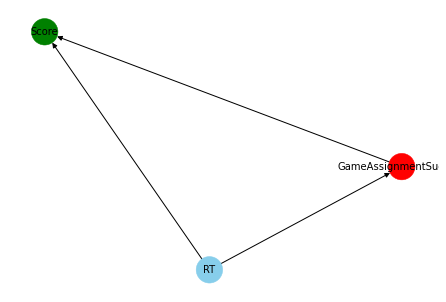

In [27]:
G = nx.parse_gml(gml_string)

# Draw the graph using Matplotlib
node_colors = ["red", "green", "skyblue"]
pos = nx.spring_layout(G)  # You can use different layout algorithms
nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=10)
plt.show()

### Get the estimand

In [28]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                         
────────────────────────(E[Score|RT])
d[GameAssignmentSuccess]             
Estimand assumption 1, Unconfoundedness: If U→{GameAssignmentSuccess} and U→Score then P(Score|GameAssignmentSuccess,RT,U) = P(Score|GameAssignmentSuccess,RT)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect
Treatment is a binary

In [29]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


In [30]:
estimate.value

### Refute
1. random common cause

In [31]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [32]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10333.75
New effect:10315.945099999999
p value:0.49



### Refute
2. Placebo treatment 

In [33]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute")

In [34]:
# p value is still greater than 0.05, our null hypothesis is good (alternative one is bad)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:10333.75
New effect:-108.8175
p value:0.49



### Refute
3. Data subset refuter

In [35]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", subset_fraction=0.9)

In [36]:
print(refutation)

Refute: Use a subset of data
Estimated effect:10333.75
New effect:10328.001055555555
p value:0.45



### Summary:
None of retuter beat our null hypothesis which means that ....

### A friendly text interpreter, for ATE

In [37]:
# Textual Interpreter
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [GameAssignmentSuccess] from 0 to 1 causes an increase of 10333.75 in the expected value of the outcome [Score], over the data distribution/population represented by the dataset.
